In [1]:
# Feature selection from previous analysis
cols = ['grade', 'int_rate', 'fico', 'bc_open_to_buy', 'acc_open_past_24mths', 
        'verification_status', 'term', 'total_bc_limit', 'num_tl_op_past_12m',
        'total_rev_hi_lim', 'tot_hi_cred_lim', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
        'avg_cur_bal', 'percent_bc_gt_75', 'bc_util', 'mths_since_recent_bc', 'annual_inc',
        'inq_last_6mths', 'dti', 'tot_cur_bal', 'revol_util', 'home_ownership', 'num_actv_rev_tl',
        'purpose', 'mo_sin_old_rev_tl_op', 'mort_acc']
cols += ['issue_d', 'credit_event']

In [2]:
# Importing Libraries
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

# Display Settings 
display = pd.options.display
display.max_columns = 100
display.max_rows = 100
display.max_colwidth = 199
display.width = 1000

In [3]:
# Working Directory & Data files
wdir = os.getcwd()
data_file_name = '\Loan_status_2007-2020Q3.gzip'

# Read Loan level data
loan_data = pd.read_csv(wdir+data_file_name, low_memory=False, index_col=False)
print(loan_data.shape) #(2925493, 142)

(2925493, 142)


In [4]:
# Cleaning data:

# Removing rows with missing issue_date or earliest_credit_line - 29 rows
loan_data = loan_data[~loan_data[['issue_d','earliest_cr_line']].isna().any(axis=1)]


# Formatting certain fields
loan_data.loc[loan_data['home_ownership'].isin(['ANY','OTHER','NONE']), 'home_ownership'] = 'MORTGAGE'

loan_data['issue_d']  = loan_data['issue_d'].apply(lambda x: datetime.strptime(x, "%b-%Y"))
loan_data['earliest_cr_line'] = loan_data['earliest_cr_line'].apply(lambda x: datetime.strptime(x, "%b-%Y"))
loan_data['credit_hist'] = loan_data['issue_d'].dt.to_period('M') - loan_data['earliest_cr_line'].dt.to_period('M')
loan_data['credit_hist'] = loan_data['credit_hist'].apply(lambda x: x.n)

loan_data['int_rate'] = loan_data['int_rate'].str[:-1].astype(float)  #Strip off the %sign
loan_data['revol_util'] = loan_data['revol_util'].str[:-1].astype(float)  #Strip off the %sign

loan_data['fico'] = 0.5*(loan_data['fico_range_low'] + loan_data['fico_range_high'])

# Encoding 'loan_status'
print(loan_data['loan_status'].value_counts())
keep_status = ['Fully Paid', 'Charged Off','Current','Default',
               'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
               #'Does not meet the credit policy. Status:Fully Paid',
               #'Does not meet the credit policy. Status:Charged Off', 
               #'Issued',
               ]
loan_data = loan_data[loan_data['loan_status'].isin(keep_status)]

# Create a Binary Credit_Event flag
credit_event_status = ['Charged Off','Default','Late (31-120 days)']
loan_data['credit_event'] = 0
loan_data.loc[loan_data['loan_status'].isin(credit_event_status), 'credit_event'] = 1

print(loan_data['loan_status'].value_counts())
print(f"Credit event distribution: \n{loan_data['credit_event'].value_counts()}")

Fully Paid                                             1497783
Current                                                1031016
Charged Off                                             362548
Late (31-120 days)                                       16154
In Grace Period                                          10028
Late (16-30 days)                                         2719
Issued                                                    2062
Does not meet the credit policy. Status:Fully Paid        1962
Does not meet the credit policy. Status:Charged Off        758
Default                                                    433
Name: loan_status, dtype: int64
Fully Paid            1497783
Current               1031016
Charged Off            362548
Late (31-120 days)      16154
In Grace Period         10028
Late (16-30 days)        2719
Default                   433
Name: loan_status, dtype: int64
Credit event distribution: 
0    2541546
1     379135
Name: credit_event, dtype: int64


In [5]:
# Curtail Dataset to shortlisted fields
loan_data = loan_data[cols]
print(loan_data.shape) #(2920681, 29)

(2920681, 29)


In [6]:
# Rearrange columns alphabetically; column name formatting is okay

loan_data = loan_data[loan_data.columns.sort_values()]
print(loan_data.columns)

Index(['acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'credit_event', 'dti', 'fico', 'grade', 'home_ownership', 'inq_last_6mths', 'int_rate', 'issue_d', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_actv_rev_tl', 'num_tl_op_past_12m', 'percent_bc_gt_75', 'purpose', 'revol_util', 'term', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_bc_limit', 'total_rev_hi_lim', 'verification_status'], dtype='object')


In [7]:
print(loan_data.isna().any(axis=1).mean()) #0.035

# Drop missing values

loan_data = loan_data[~loan_data.isna().any(axis=1)]
print(loan_data.shape) #(2815835, 29)

0.03589779232993949
(2815835, 29)


In [8]:
# Identifying Categorical Features
cat_features = loan_data.columns[loan_data.dtypes == object].to_list()
cat_features #['grade', 'home_ownership', 'purpose', 'term', 'verification_status']
loan_data['grade'].unique(), loan_data['home_ownership'].unique(), loan_data['purpose'].unique(),\
loan_data['term'].unique(), loan_data['verification_status'].unique()

(array(['B', 'A', 'C', 'D', 'E', 'F', 'G'], dtype=object),
 array(['RENT', 'MORTGAGE', 'OWN'], dtype=object),
 array(['debt_consolidation', 'home_improvement', 'other', 'credit_card',
        'major_purchase', 'small_business', 'house', 'moving', 'medical',
        'car', 'vacation', 'renewable_energy', 'wedding', 'educational'],
       dtype=object),
 array([' 36 months', ' 60 months'], dtype=object),
 array(['Not Verified', 'Source Verified', 'Verified'], dtype=object))

In [9]:
# Creating Dummy variables
for col in cat_features:
    df_dummy = pd.get_dummies(loan_data[col], prefix=col, prefix_sep='_', drop_first=True)
    loan_data = pd.concat([loan_data, df_dummy], axis=1)

print(loan_data.shape) #(2815835, 53)
loan_data.drop(columns=cat_features, inplace=True)
print(loan_data.shape) #(2815835, 48)

(2815835, 53)
(2815835, 48)


In [10]:
# Separating Data into Train, Test and Validation (out-of-sample)
# Reference https://machinelearningmastery.com/difference-test-validation-datasets/

cutoff_date = '2019-09-01'
loan_data_val = loan_data[loan_data['issue_d'] >  cutoff_date]
loan_data_dev = loan_data[loan_data['issue_d'] <= cutoff_date]
loan_data_train, loan_data_test = train_test_split(loan_data_dev, test_size = 0.3, random_state=693)

loan_data_val.drop(columns = 'issue_d', inplace = True)
loan_data_dev.drop(columns = 'issue_d', inplace = True)
loan_data_train.drop(columns = 'issue_d', inplace = True)
loan_data_test.drop(columns = 'issue_d', inplace = True)

loan_data_val.reset_index(drop=True, inplace=True)
loan_data_dev.reset_index(drop=True, inplace=True)
loan_data_train.reset_index(drop=True, inplace=True)
loan_data_test.reset_index(drop=True, inplace=True)


C:\Users\uditg\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
print('Validation data: {}, contains {:1.2f}% of total data'.\
      format(loan_data_val.shape, 100*loan_data_val.shape[0]/loan_data.shape[0]))
print('Validation data - distribution of credit events:\n{}'.\
      format(loan_data_val['credit_event'].value_counts()))

print('Development data: {}, contains {:1.2f}% of total data'.\
      format(loan_data_dev.shape, 100*loan_data_dev.shape[0]/loan_data.shape[0]))
print('Development data - distribution of credit events:\n{}'.\
      format(loan_data_dev['credit_event'].value_counts()))

print('Train data: {}, contains {:1.2f}% of total data'.\
      format(loan_data_train.shape, 100*loan_data_train.shape[0]/loan_data.shape[0]))
print('Train data - distribution of credit events:\n{}'.\
      format(loan_data_train['credit_event'].value_counts()))

print('Test data: {}, contains {:1.2f}% of total data'.\
      format(loan_data_test.shape, 100*loan_data_test.shape[0]/loan_data.shape[0]))
print('Test data - distribution of credit events:\n{}'.\
      format(loan_data_test['credit_event'].value_counts()))

Validation data: (269280, 47), contains 9.56% of total data
Validation data - distribution of credit events:
0    267018
1      2262
Name: credit_event, dtype: int64
Development data: (2546555, 47), contains 90.44% of total data
Development data - distribution of credit events:
0    2184839
1     361716
Name: credit_event, dtype: int64
Train data: (1782588, 47), contains 63.31% of total data
Train data - distribution of credit events:
0    1529280
1     253308
Name: credit_event, dtype: int64
Test data: (763967, 47), contains 27.13% of total data
Test data - distribution of credit events:
0    655559
1    108408
Name: credit_event, dtype: int64


In [12]:
loan_data_train.head()

,acc_open_past_24mths,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,credit_event,dti,fico,inq_last_6mths,int_rate,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_actv_rev_tl,num_tl_op_past_12m,percent_bc_gt_75,revol_util,tot_cur_bal,tot_hi_cred_lim,total_bc_limit,total_rev_hi_lim,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,verification_status_Source Verified,verification_status_Verified
0,6.0,40500.0,12586.0,4395.0,67.9,0,21.43,677.0,1.0,10.33,83.0,4.0,4.0,2.0,7.0,5.0,4.0,60.0,65.0,138449.0,153879.0,13700.0,21500.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,6.0,91000.0,23166.0,1546.0,86.6,0,32.90,702.0,0.0,14.46,150.0,3.0,3.0,5.0,3.0,5.0,3.0,50.0,67.1,277995.0,319594.0,11500.0,19200.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,14.0,72000.0,8249.0,309.0,84.5,0,18.33,687.0,2.0,16.99,126.0,2.0,2.0,1.0,84.0,4.0,5.0,100.0,28.3,74243.0,97331.0,2000.0,7600.0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3.0,24000.0,4940.0,18759.0,35.5,0,23.70,717.0,0.0,10.33,145.0,3.0,3.0,0.0,19.0,2.0,1.0,0.0,28.6,29640.0,59482.0,29100.0,36100.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1.0,19644.0,21695.0,439.0,75.6,0,12.49,672.0,0.0,11.71,197.0,9.0,9.0,2.0,105.0,2.0,1.0,100.0,50.5,86780.0,94300.0,1800.0,5300.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [13]:
# Fit Logistic Regression Model - no cross validation, using full development data

x_train = loan_data_dev.drop(columns = 'credit_event')
y_train = loan_data_dev['credit_event']

num_features = list(x_train.columns[(x_train.dtypes == 'float64')])
print(len(num_features))

scaling = StandardScaler()
x_train[num_features] = scaling.fit_transform(x_train[num_features])

model_lr = LogisticRegression(solver='sag',class_weight=None,max_iter=100)
# “sag” solver uses Stochastic Average Gradient descent. 
# It is faster than other solvers for large datasets, when both the number of samples and the number of features are large.

model_lr.fit(x_train, y_train)

22


C:\Users\uditg\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(solver='sag')

In [14]:
model_lr.score(x_train, y_train) #0.85 - predicting everything is 0 would itself be ~0.84 accurate

0.857837352815863

In [15]:
x_val = loan_data_val.drop(columns = 'credit_event')
x_val[num_features] = scaling.transform(x_val[num_features])
y_val = loan_data_val['credit_event']

model_lr.score(x_val, y_val) #0.99 - validation data set is highly imbalanced; the score alone doesn't tell much

0.991061348781937

In [16]:
# Cross Validation
# scores = cross_val_score(model_lr, x_train, y_train, cv=5)
# print(scores, np.mean(scores)) 
#[0.85767831 0.85765672 0.85653952 0.85771169 0.85730722] 0.8573786939610573

No-Skill: AUC=0.702
Model: AUC=0.500
YoudenJ threshold: 0.1395


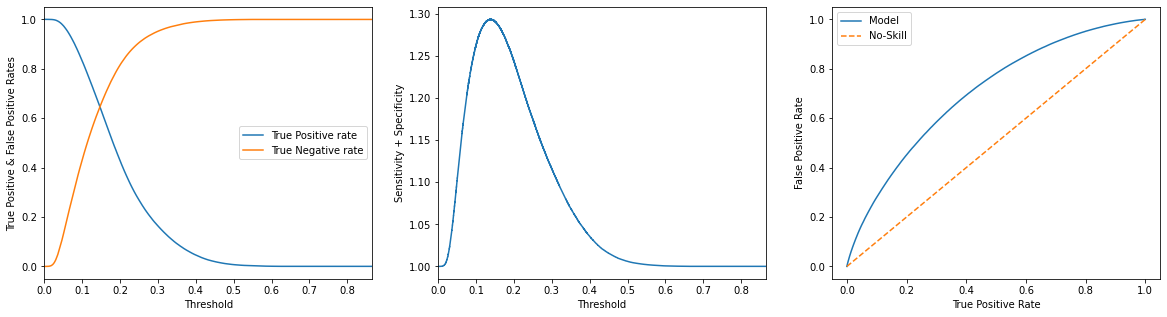

In [17]:
# ROC/ AUC
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

def model_ROC(x, y, model):
    y_prob_model = model.predict_proba(x)[:,1]
    y_prob_null = [0]*len(y)
    
    fpr, tpr, threshold = roc_curve(y, y_prob_model)
    fpr_null, tpr_null, _ = roc_curve(y, y_prob_null)

    xmax = max(model.predict_proba(x)[:,1])

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
    
    # tpr = TP/TP+FN = Sensitivity/ Recall
    # tnr = 1-fpr = TN/TN+FP = Specificity
    
    ax[0].plot(threshold, tpr, label="True Positive rate")
    ax[0].plot(threshold, 1-fpr, label="True Negative rate")   
    ax[0].legend()
    ax[0].set_xlabel('Threshold')
    ax[0].set_ylabel('True Positive & False Positive Rates')
    ax[0].set_xlim([0,xmax])

    ax[1].plot(threshold, tpr + (1 - fpr))
    ax[1].set_xlabel('Threshold')
    ax[1].set_ylabel('Sensitivity + Specificity')
    ax[1].set_xlim([0,xmax])

    ax[2].plot(fpr, tpr, linestyle='-', label='Model')
    ax[2].plot(fpr_null, tpr_null, linestyle='--', label='No-Skill')
    ax[2].set_xlabel('True Positive Rate')
    ax[2].set_ylabel('False Positive Rate')
    ax[2].legend()
   
    print('No-Skill: AUC=%.3f' % (roc_auc_score(y, y_prob_model)))
    print('Model: AUC=%.3f' % (roc_auc_score(y, y_prob_null)))  
    
    # https://en.wikipedia.org/wiki/Youden%27s_J_statistic
    return threshold[np.argmax(tpr + (1 - fpr))]

thresh_yj_train = model_ROC(x_train, y_train, model_lr)
print('YoudenJ threshold: {:1.4f}'.format(thresh_yj_train) )

No-Skill: AUC=0.665
Model: AUC=0.500
YoudenJ threshold: 0.1306


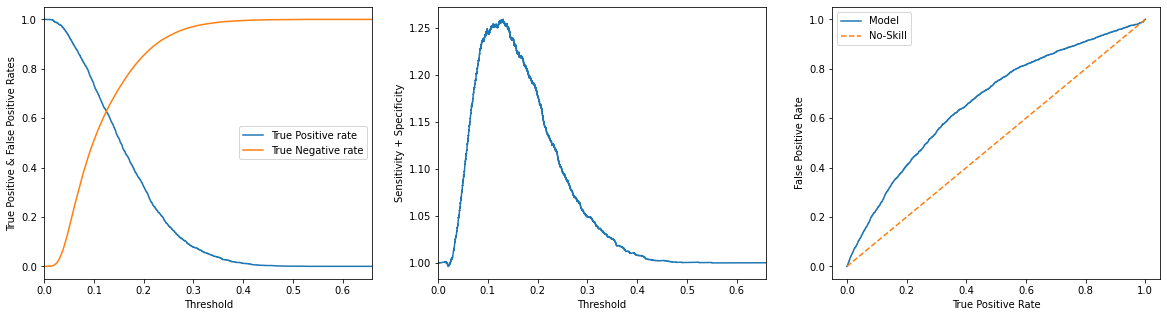

In [18]:
thresh_yj_val = model_ROC(x_val, y_val, model_lr)
print('YoudenJ threshold: {:1.4f}'.format(thresh_yj_val) )

<ipython-input-19-ae55f5e225f0>:10: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall)/(precision + recall)


Fscore Threshold=0.1676, Fscore=0.3446


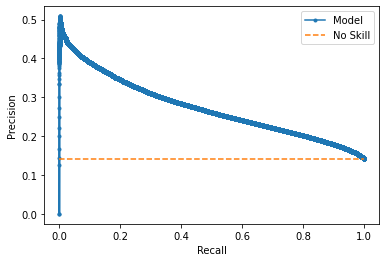

In [19]:
# https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

def model_F_score(x, y, model):
    y_prob_model = model.predict_proba(x)[:,1]

    # Compute precision-recall pairs for different probability thresholds
    precision, recall, thresholds = precision_recall_curve(y, y_prob_model)
    
    fscore = (2 * precision * recall)/(precision + recall)
    fscore_max = max(fscore)
    
    # Thresholds length is 1 less than Precision & Recall vectors (refer documentation)
    threshold_best = thresholds[fscore[:-1] == max(fscore)][0]
       
    print('Fscore Threshold={:1.4f}, Fscore={:1.4f}'.format(threshold_best, fscore_max))
    
    
    no_skill = len(y[y==1])/len(y)
    
    plt.plot(recall[:-1], precision[:-1], marker='.', label='Model')
    plt.plot([0,1], [no_skill, no_skill], linestyle='--', label='No Skill')  #TBD
    plt.legend()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    return threshold_best, fscore_max

thresh_f_train, fscore_train = model_F_score(x_train, y_train, model_lr)

In [20]:
# thresh_f_train, fscore_train = model_F_score(x_val, y_val, model) #Fscore Threshold=0.2389

In [21]:
# Confusion Matrix
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

def model_cmatrix(x, y, model, threshold):
    y_prob_model = model.predict_proba(x)[:,1]
    y_prediction = np.where(y_prob_model >= threshold, 1, 0)

    confusion = confusion_matrix(y, y_prediction)

    sns.heatmap(confusion, annot=True, fmt="0", cmap='Blues');
    plt.xlabel('Prediction')
    plt.ylabel('Actuals')
    
    return confusion    

array([[1345826,  839013],
       [ 116712,  245004]], dtype=int64)

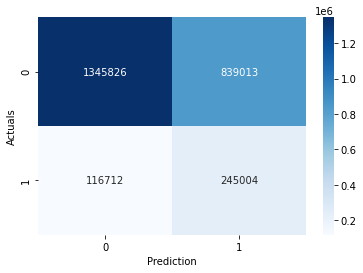

In [22]:
model_cmatrix(x_train, y_train, model_lr, thresh_yj_train)

array([[1573948,  610891],
       [ 159270,  202446]], dtype=int64)

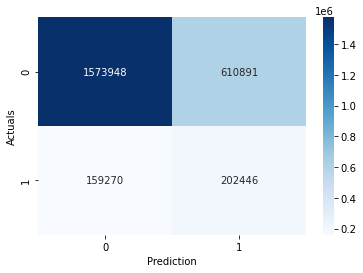

In [23]:
model_cmatrix(x_train, y_train, model_lr, thresh_f_train)

array([[182565,  84453],
       [   979,   1283]], dtype=int64)

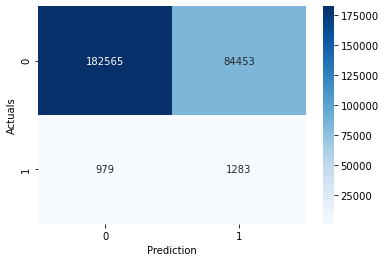

In [24]:
model_cmatrix(x_val, y_val, model_lr, thresh_yj_train)

### Next Steps ###
* Feature transformation might improve the model fit
* Try more complicated models, such as Random Forest

In [ ]:
# TBD

#from sklearn.ensemble import RandomForestClassifier

#model_rf = RandomForestClassifier(n_estimators=500)
#model_rf.fit(x_train, y_train)


#thresh_yj_train = model_ROC(x_train, y_train, model_rf)
#print('YoudenJ threshold: {:1.4f}'.format(thresh_yj_train) )

#model_cmatrix(x_val, y_val, model_rf, thresh_yj_train)